In [43]:
from load_data import load_data
import os
from matplotlib import pyplot as plt
import numpy as np
import cv2


In [44]:
%config Completer.use_jedi = False

In [45]:
def print_image(image_data):
    plt.imshow(image_data, interpolation='nearest')
    plt.show()

In [46]:
data = load_data(os.getcwd()+"/data/data.p")

In [47]:
data['objects'][0]

['Car',
 0.0,
 0.0,
 -1.7238,
 683.9335,
 181.8529,
 754.8935,
 232.4525,
 1.4339,
 1.5592,
 3.9817,
 3.3338,
 1.3397,
 22.3635,
 -1.5781,
 0.8312]

# Task 1 Bird's Eye of View

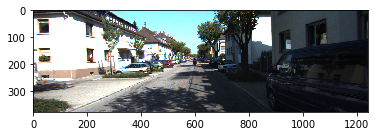

In [48]:
print_image(data['image_2'])

In [28]:
import numpy as np
import matplotlib.pyplot as plt

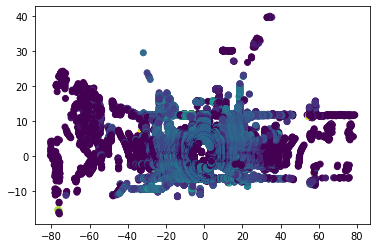

In [40]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(data['velodyne'][:,0],data['velodyne'][:,1],c = data['velodyne'][:,-1])

In [69]:
min_height = np.min(data['velodyne'][:,-2])
max_height = np.max(data['velodyne'][:,-2])

In [76]:
im = birds_eye_point_cloud(data['velodyne'],min_height=min_height,max_height=max_height)

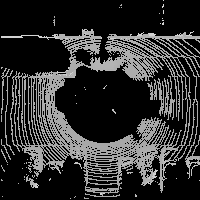

In [77]:
im.rotate(90)

In [63]:
from PIL import Image
import numpy as np

# ==============================================================================
#                                                                   SCALE_TO_255
# ==============================================================================
def scale_to_255(a, min, max, dtype=np.uint8):
    """ Scales an array of values from specified min, max range to 0-255
        Optionally specify the data type of the output (default is uint8)
    """
    return (((a - min) / float(max - min)) * 255).astype(dtype)


# ==============================================================================
#                                                          BIRDS_EYE_POINT_CLOUD
# ==============================================================================
def birds_eye_point_cloud(points,
                          side_range=(, 10),
                          fwd_range=(-10,10),
                          res=0.2,
                          min_height = -2.73,
                          max_height = 5,
                          saveto='text_image.jpg'):
    """ Creates an 2D birds eye view representation of the point cloud data.
        You can optionally save the image to specified filename.

    Args:
        points:     (numpy array)
                    N rows of points data
                    Each point should be specified by at least 3 elements x,y,z
        side_range: (tuple of two floats)
                    (-left, right) in metres
                    left and right limits of rectangle to look at.
        fwd_range:  (tuple of two floats)
                    (-behind, front) in metres
                    back and front limits of rectangle to look at.
        res:        (float) desired resolution in metres to use
                    Each output pixel will represent an square region res x res
                    in size.
        min_height:  (float)(default=-2.73)
                    Used to truncate height values to this minumum height
                    relative to the sensor (in metres).
                    The default is set to -2.73, which is 1 metre below a flat
                    road surface given the configuration in the kitti dataset.
        max_height: (float)(default=1.27)
                    Used to truncate height values to this maximum height
                    relative to the sensor (in metres).
                    The default is set to 1.27, which is 3m above a flat road
                    surface given the configuration in the kitti dataset.
        saveto:     (str or None)(default=None)
                    Filename to save the image as.
                    If None, then it just displays the image.
    """
    x_lidar = points[:, 0]
    y_lidar = points[:, 1]
    z_lidar = points[:, 2]
    # r_lidar = points[:, 3]  # Reflectance

    # INDICES FILTER - of values within the desired rectangle
    # Note left side is positive y axis in LIDAR coordinates
    ff = np.logical_and((x_lidar > fwd_range[0]), (x_lidar < fwd_range[1]))
    ss = np.logical_and((y_lidar > -side_range[1]), (y_lidar < -side_range[0]))
    indices = np.argwhere(np.logical_and(ff,ss)).flatten()

    # CONVERT TO PIXEL POSITION VALUES - Based on resolution
    x_img = (-y_lidar[indices]/res).astype(np.int32) # x axis is -y in LIDAR
    y_img = (x_lidar[indices]/res).astype(np.int32)  # y axis is -x in LIDAR
                                                     # will be inverted later

    # SHIFT PIXELS TO HAVE MINIMUM BE (0,0)
    # floor used to prevent issues with -ve vals rounding upwards
    x_img -= int(np.floor(side_range[0]/res))
    y_img -= int(np.floor(fwd_range[0]/res))

    # CLIP HEIGHT VALUES - to between min and max heights
    pixel_values = np.clip(a = z_lidar[indices],
                           a_min=min_height,
                           a_max=max_height)

    # RESCALE THE HEIGHT VALUES - to be between the range 0-255
    pixel_values  = scale_to_255(pixel_values, min=min_height, max=max_height)

    # FILL PIXEL VALUES IN IMAGE ARRAY
    x_max = int((side_range[1] - side_range[0])/res)
    y_max = int((fwd_range[1] - fwd_range[0])/res)
    im = np.zeros([y_max, x_max], dtype=np.uint8)
    im[-y_img, x_img] = pixel_values # -y because images start from top left

    # Convert from numpy array to a PIL image
    im = Image.fromarray(im)
    
    # SAVE THE IMAGE
    if saveto is not None:
        im.save(saveto)
    else:
        im.show()
    return im

SyntaxError: invalid syntax (<ipython-input-63-f63146e12d31>, line 18)

# Task 2

In [85]:
!pip3 install vispy

    100% |████████████████████████████████| 2.3MB 615kB/s eta 0:00:01
    100% |████████████████████████████████| 890kB 1.3MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/45/b2/6c7545bb7a38754d63048c7696804a0d947328125d81bf12beaa692c3ae3/numpy-1.19.5-cp36-cp36m-manylinux1_x86_64.whl


In [ ]:
import vispy
from vispy.scene import visuals, SceneCanvas
import numpy as np
import os
from load_data import load_data

class Visualizer():
    def __init__(self):
        self.canvas = SceneCanvas(keys='interactive', show=True)
        self.grid = self.canvas.central_widget.add_grid()
        self.view = vispy.scene.widgets.ViewBox(border_color='white',
                        parent=self.canvas.scene)
        self.grid.add_widget(self.view, 0, 0)

        # Point Cloud Visualizer
        self.sem_vis = visuals.Markers()
        self.view.camera = vispy.scene.cameras.TurntableCamera(up='z', azimuth=90)
        self.view.add(self.sem_vis)
        visuals.XYZAxis(parent=self.view.scene)
        
        # Object Detection Visualizer
        self.obj_vis = visuals.Line()
        self.view.add(self.obj_vis)
        self.connect = np.asarray([[0,1],[0,3],[0,4],
                                   [2,1],[2,3],[2,6],
                                   [5,1],[5,4],[5,6],
                                   [7,3],[7,4],[7,6]])

    def update(self, points):
        '''
        :param points: point cloud data
                        shape (N, 3)          
        Task 2: Change this function such that each point
        is colored depending on its semantic label
        '''
        self.sem_vis.set_data(points, size=3)
    
    def update_boxes(self, corners):
        '''
        :param corners: corners of the bounding boxes
                        shape (N, 8, 3) for N boxes
        (8, 3) array of vertices for the 3D box in
        following order:
            1 -------- 0
           /|         /|
          2 -------- 3 .
          | |        | |
          . 5 -------- 4
          |/         |/
          6 -------- 7
        If you plan to use a different order, you can
        change self.connect accordinly.
        '''
        for i in range(corners.shape[0]):
            connect = np.concatenate((connect, self.connect+8*i), axis=0) \
                      if i>0 else self.connect
        self.obj_vis.set_data(corners.reshape(-1,3),
                              connect=connect,
                              width=2,
                              color=[0,1,0,1])

In [79]:
P2 = data['P_rect_20']

In [80]:
P2

array([[ 7.188560e+02,  0.000000e+00,  6.071928e+02,  4.538225e+01],
       [ 0.000000e+00,  7.188560e+02,  1.852157e+02, -1.130887e-01],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  3.779761e-03]])

In [ ]:
data['']

In [82]:
np.concatenate((data['velodyne'][:,:-1]

array([[75.44401  ,  6.459378 ,  2.7706459],
       [75.16147  ,  6.673324 ,  2.7616658],
       [75.483376 ,  7.180198 ,  2.7747202],
       ...,
       [ 3.8458116, -1.4298368, -1.7671217],
       [ 3.844254 , -1.415847 , -1.765138 ],
       [ 3.847988 , -1.4108514, -1.7661463]], dtype=float32)